# Preprocessing

En este NB se explora el impacto de las funciones de preprocesamiento que se implementen:

## Importaciones

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import os
import numpy as np
import matplotlib.pylab as plt
from art.estimators.classification import PyTorchClassifier
import cv2

## Procesamiento y carga de datos

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Preprocessing
transform_test = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)

# Data Loading
testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform_test
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=128, shuffle=False, num_workers=2
)

Files already downloaded and verified


## Funciones para normalizar y desnormalizar los datos

In [3]:
# Function to denormalize image
def denormalize(tensor, mean, std):
    denorm = torch.clone(tensor)
    for t, m, s in zip(denorm, mean, std):
        t.mul_(s).add_(m)
    return denorm


def normalize(tensor, mean, std):
    norm = torch.clone(tensor)
    for t, m, s in zip(norm, mean, std):
        t.sub_(m).div_(s)
    return norm


# Denormalize images
mean = torch.tensor([0.4914, 0.4822, 0.4465], dtype=torch.float32)
std = torch.tensor([0.2023, 0.1994, 0.2010], dtype=torch.float32)

## Funciones para cargar los modelos

In [4]:
# Function to init the model
def init_model(lr=0.001, model_name="Resnet"):
    if model_name == "Resnet":
        model = models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)
    elif model_name == "Regnet_X":
        model = models.regnet_x_400mf(
            weights=torchvision.models.RegNet_X_400MF_Weights.DEFAULT
        )
    elif model_name == "Regnet_Y":
        model = models.regnet_y_400mf(
            weights=torchvision.models.RegNet_Y_400MF_Weights.DEFAULT
        )

    # Fine-tuning: Replace the last layer (classifier)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 10)
    # Move model to GPU if available
    model = model.to(device)
    if device == "cuda":
        model = torch.nn.DataParallel(model)
        cudnn.benchmark = True
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
    return model, criterion, optimizer, scheduler

# Function to load the model
def load_model(model, name="ckpt.pth"):
    global best_acc
    print("==> Resuming from checkpoint..")
    assert os.path.isdir("checkpoint"), "Error: no checkpoint directory found!"
    if device == "cuda":
        checkpoint = torch.load("./checkpoint/" + name)
    else:
        checkpoint = torch.load(
            "./checkpoint/" + name, map_location=torch.device("cpu")
        )
    model.load_state_dict(checkpoint["model"])
    best_acc = checkpoint["acc"]
    start_epoch = checkpoint["epoch"]
    return start_epoch, best_acc

## Función para cargar un modelo según el nombre

In [5]:
def classification(name_model):
    model, criterion, optimizer, scheduler = init_model(model_name=name_model[:-4])
    metrics = load_model(model, name=name_model)
    if device == "cuda":
        device_type = "gpu"
    else:
        device_type = "cpu"
    classifier = PyTorchClassifier(
        model=model,
        loss=criterion,
        optimizer=optimizer,
        nb_classes=10,
        input_shape=(3, 32, 32),
        device_type=device_type,
    )
    return classifier

## Cargar los datos de los ejemplos adversariales

In [6]:
adversarial_resnet = torch.load("./Adversarial_examples/FastGradient_Method/all_data_denormed_Resnet.pt")
adversarial_regnet_x = torch.load("./Adversarial_examples/FastGradient_Method/all_data_denormed_Regnet_X.pt")
adversarial_regnet_y = torch.load("./Adversarial_examples/FastGradient_Method/all_data_denormed_Regnet_Y.pt")
adver_data = {
    "Resnet": adversarial_resnet,
    "Regnet_X": adversarial_regnet_x,
    "Regnet_Y": adversarial_regnet_y
}

## Pre processing

Write a number 78


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


==> Resuming from checkpoint..


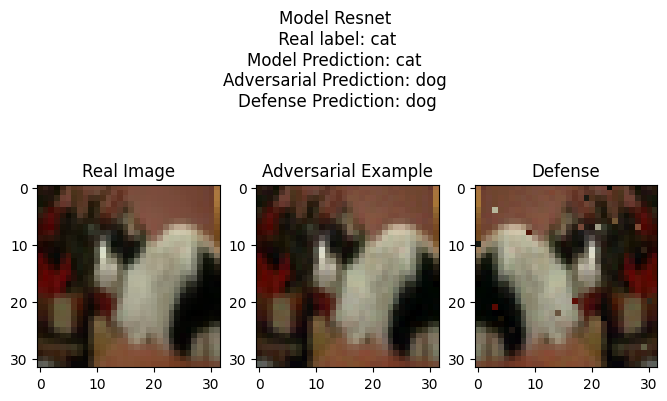

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


==> Resuming from checkpoint..


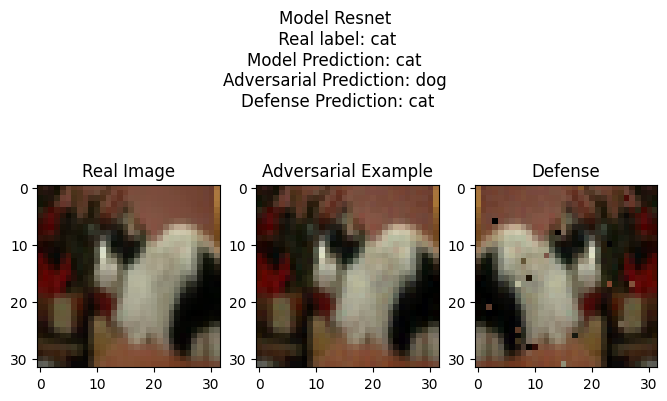

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


==> Resuming from checkpoint..


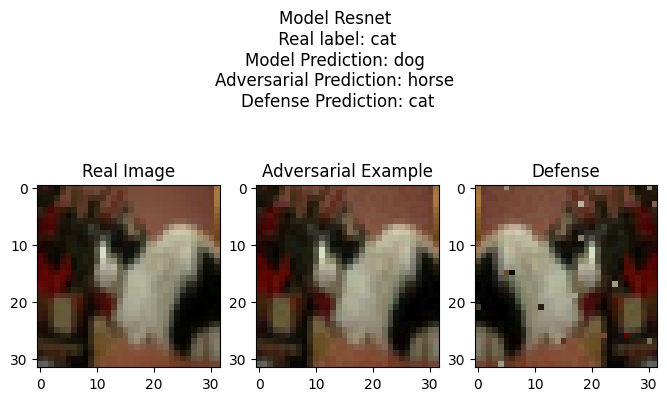

In [9]:
n = int(input('Write a number'))

for key, adver in adver_data.items():
    
    # Get the image
    image = adver["examples"][n].cpu().detach().numpy().transpose((1, 2, 0))
    
    # PREPROCESS 1: Distortion moving pixels
    pixels = 20
    h, w, ch = image.shape
    dist_image = image.copy()
    for _ in range(pixels):
        x1, y1 = np.random.randint(0, w), np.random.randint(0, h)
        x2, y2 = np.random.randint(0, w), np.random.randint(0, h)
        dist_image[x1, y1], dist_image[x2, y2] = (
            dist_image[x2, y2],
            dist_image[x1, y1],
        )
    
    # PREPROCESS 2: Horizontal Flip
    flip = cv2.flip(dist_image, 1)
    
    # Defense Prediction
    classifier = classification(name_model = key+".pth")
    defense = torch.tensor(flip.transpose((2, 0, 1)))
    norm = normalize(defense, mean, std)
    pred = np.argmax(classifier.predict(norm.unsqueeze(0)))
    defense = denormalize(norm, mean, std)
    
    # Plot the results and compare
    title = str(f"Model Resnet \n Real label: {testset.classes[adver['real_labels'][n]]} \n" +
        f"Model Prediction: {testset.classes[adver['model_labels'][n]]} \n" + 
        f"Adversarial Prediction: {testset.classes[adver['adversarial_labels'][n]]} \n" + 
        f"Defense Prediction: {testset.classes[pred]}")
    fig, ax = plt.subplots(1, 3, figsize=(8, 5.5))
    ax[0].imshow(denormalize(testset[n][0], mean, std).numpy().transpose((1, 2, 0)))
    ax[0].set_title("Real Image")
    ax[1].imshow(image)
    ax[1].set_title("Adversarial Example")
    ax[2].imshow(defense.numpy().transpose((1, 2, 0)))
    ax[2].set_title("Defense")
    plt.suptitle(title)
    plt.show()